# Capstone Project - The Battle of Neighborhoods

### Introduction
&nbsp;&nbsp;&nbsp;&nbsp;Thai immigrants to Canada are primarily well-educated professionals working
as bankers, dentists, doctors, nurses, computer technicians and engineers. 
Many of them closed businesses such as Thai restaurants or Muay Thai gyms, 
which has become popular in Canada.

&nbsp;&nbsp;&nbsp;&nbsp;Thai cooking places emphasis on lightly prepared dishes with strong aromatic 
components and a spicy edge. Thai chef McDang characterises Thai food as 
demonstrating "intricacy; attention to detail; texture; color; taste; and the use 
of ingredients with medicinal benefits, as well as good flavor", as well as 
care being given to the food's appearance, smell and context.

&nbsp;&nbsp;&nbsp;&nbsp;So as part of this project, we will list and visualize all major parts of 
Toronto that has poppular Thai restaurants.

### Data 
For this project we need the following data :
<ul>
<li> Toronto,CA data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M </br>
            and get latitude,longitude from https://cocl.us/Geospatial_data'
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     </ul>
<li> Thai resturants in each neighborhood of Toronto city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://github.com/jasonicarter/toronto-geojson/blob/master/toronto_topo.json
        <li> Description : By using this geo space data we will get the Toronto Borough boundaries that will help us visualize choropleth map.
  
</ul>

### Approach
- Collect the postal code,borough,neighborhood of Toronto city data from wikipedia
- Collect latitude,longitude data from https://cocl.us/Geospatial_data
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Thai Resturants.
- Find rating , tips and like count for each Thai Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Defined the problems
 As a Thai food business, seeing the picture in business for Thai restuarnats, so we would like to find out about the business </br>
-Best Places in Toronto city for Thai cuisine </br>
-which areas have the potential to market for Thai Resturant </br>
-which is the best place to stay if I like Thai food

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- folium to visualize the results on a map

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
import folium # map rendering library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:
CLIENT_ID = 'UXHU0HKZNB2QXHWARJCIHZLB15NKOFC2E1PBXGXWQFUPU1GG' # your Foursquare ID
CLIENT_SECRET = 'MJT44QTU0ILSJFXW4A5EE3EMY3C5TAG4HC3X1G3UN4F5TMFC' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius = 1000
category='4d4b7105d754a06374d81259'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UXHU0HKZNB2QXHWARJCIHZLB15NKOFC2E1PBXGXWQFUPU1GG
CLIENT_SECRET:MJT44QTU0ILSJFXW4A5EE3EMY3C5TAG4HC3X1G3UN4F5TMFC


We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
def get_venues(lat,lng):

    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [5]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()

    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we get the Toronto city data such as Boroughs, Neighborhoods along with their latitude and longitude.

We will get the Toronto city data from wikipedia and get latitude and longitude from 
geodata.

In [6]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(website_url,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]

    if row:
        # ignore cell with boroage is nan
        if row[1] != 'Not assigned':
            if row[2]=='Not assigned':
               row[2]=row[1]
            res.append(row)
df = pd.DataFrame(res, columns=["Postcode", "Borough", "Neighborhood"])
df_group = df.groupby(['Postcode', 'Borough']).apply(lambda group: ','.join(group['Neighborhood']))
df_postcode = df_group.to_frame().reset_index()
df_postcode.columns = ['Postcode', 'Borough', 'Neighborhood']
locgeo_df = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code')
toronto_data = df_postcode.join(locgeo_df, on='Postcode')
toronto_data.drop('Postcode', axis=1, inplace=True)
toronto_data.shape

(103, 4)

So there are total of 103 different Neighborhoods in Toronto

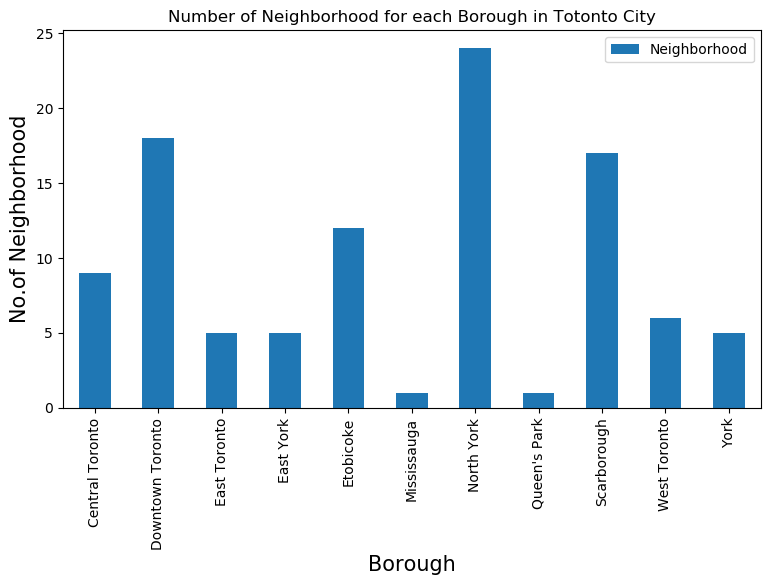

In [7]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Totonto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
toronto_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that North York has highest number of neighborhoods

Now we will collect Thai resturants for each Neighborhood

In [8]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
thai_rest_toronto=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    thai_resturants=venues[venues['Category']=='Thai Restaurant']   
    print('(',count,'/',len(toronto_data),')','Thai Resturants in '+Neighborhood+', '+Borough+':'+str(len(thai_resturants)))
    for resturant_detail in thai_resturants.values.tolist():
        id, name , category=resturant_detail
        thai_rest_toronto = thai_rest_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Thai Resturants in Rouge,Malvern, Scarborough:0
( 2 / 103 ) Thai Resturants in Highland Creek,Rouge Hill,Port Union, Scarborough:0
( 3 / 103 ) Thai Resturants in Guildwood,Morningside,West Hill, Scarborough:0
( 4 / 103 ) Thai Resturants in Woburn, Scarborough:0
( 5 / 103 ) Thai Resturants in Cedarbrae, Scarborough:1
( 6 / 103 ) Thai Resturants in Scarborough Village, Scarborough:0
( 7 / 103 ) Thai Resturants in East Birchmount Park,Ionview,Kennedy Park, Scarborough:0
( 8 / 103 ) Thai Resturants in Clairlea,Golden Mile,Oakridge, Scarborough:0
( 9 / 103 ) Thai Resturants in Cliffcrest,Cliffside,Scarborough Village West, Scarborough:0
( 10 / 103 ) Thai Resturants in Birch Cliff,Cliffside West, Scarborough:1
( 11 / 103 ) Thai Resturants in Dorset Park,Scarborough Town Centre,Wexford Heights, Scarborough:0
( 12 / 103 ) Thai Resturants in Maryvale,Wexford, Scarborough:0
( 13 / 103 ) Thai Resturants in Agincourt, Scarborough:0
( 14 / 103 ) Thai Resturants in Clarks Corners,Sulliva

Now that we have got all the Thai resturants in Toronto,CA , we will analyze it

In [9]:
thai_rest_toronto.shape

(56, 4)

We got 56 Thai Resturants across Toronto City

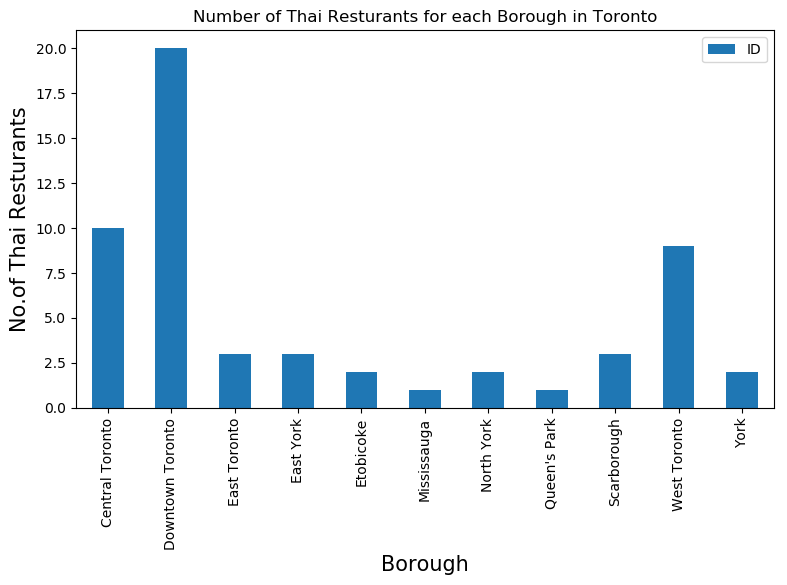

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Thai Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Thai Resturants', fontsize=15)
#giving a bar plot
thai_rest_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Downtown Toronto has the largest number of Thai resturants

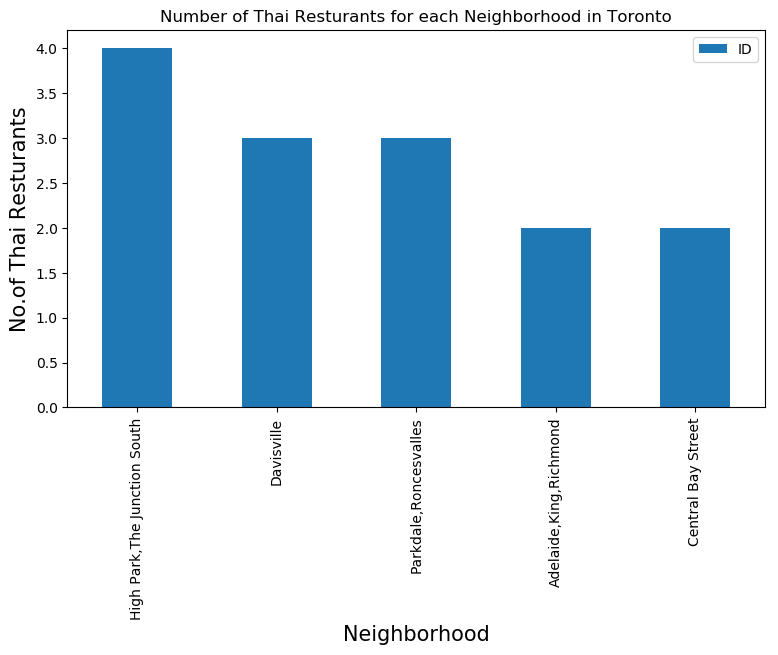

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Thai Resturants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Thai Resturants', fontsize=15)
#giving a bar plot
thai_rest_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

we see thai High park,The Junction South neighborhodd have hieihest Thai Restaurant.

In [12]:
thai_rest_toronto[thai_rest_toronto['Borough']=='Downtown Toronto']
thai_rest_toronto.head()

,Borough,Neighborhood,ID,Name
0,Scarborough,Cedarbrae,4c27da423492a593158cb628,Thai One On
1,Scarborough,"Birch Cliff,Cliffside West",511732bbe4b066680f965200,Jatujak
2,Scarborough,"Clarks Corners,Sullivan,Tam O'Shanter",56fdaefd498e27417498764c,Kub Khao
3,North York,Don Mills North,4af0bb68f964a520aade21e3,Thai One On
4,East York,Woodbine Heights,4e18729fb3ad8e08699ec3bb,Little Coxwell Restaurant


Now we will get the ranking of each resturant for further analysis.

In [13]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
thai_rest_stats_toronto=pd.DataFrame(columns=column_names)
count=1
for row in thai_rest_toronto.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(thai_rest_toronto),')','processed')
    thai_rest_stats_toronto = thai_rest_stats_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID         Name  Likes  Rating  Tips
0  4c27da423492a593158cb628  Thai One On      4     6.4     8
( 1 / 56 ) processed
                         ID     Name  Likes  Rating  Tips
0  511732bbe4b066680f965200  Jatujak     19     8.4    10
( 2 / 56 ) processed
                         ID      Name  Likes  Rating  Tips
0  56fdaefd498e27417498764c  Kub Khao     12     6.6    11
( 3 / 56 ) processed
                         ID         Name  Likes  Rating  Tips
0  4af0bb68f964a520aade21e3  Thai One On      7     6.3     6
( 4 / 56 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4e18729fb3ad8e08699ec3bb  Little Coxwell Restaurant     19     7.1    13
( 5 / 56 ) processed
                         ID         Name  Likes  Rating  Tips
0  4adb78e8f964a520d82721e3  Green Basil      9     6.7    15
( 6 / 56 ) processed
                         ID                            Name  Likes  Rating  \
0  58f3a1972b98444cc96f4c53  Sala Mode

So we got data for all resturants
Now lets save this data to a csv sheet. In case we by mistake modify it.
As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [14]:
thai_rest_stats_toronto.to_csv('thai_rest_stats_toronto.csv', index=False)

Lets verify the data from saved csv file

In [15]:
thai_rest_stats_toronto_csv=pd.read_csv('thai_rest_stats_toronto.csv')

In [16]:
thai_rest_stats_toronto_csv.shape

(56, 7)

In [17]:
thai_rest_stats_toronto_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Scarborough,Cedarbrae,4c27da423492a593158cb628,Thai One On,4,6.4,8
1,Scarborough,"Birch Cliff,Cliffside West",511732bbe4b066680f965200,Jatujak,19,8.4,10
2,Scarborough,"Clarks Corners,Sullivan,Tam O'Shanter",56fdaefd498e27417498764c,Kub Khao,12,6.6,11
3,North York,Don Mills North,4af0bb68f964a520aade21e3,Thai One On,7,6.3,6
4,East York,Woodbine Heights,4e18729fb3ad8e08699ec3bb,Little Coxwell Restaurant,19,7.1,13


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [18]:
thai_rest_stats_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 7 columns):
Borough         56 non-null object
Neighborhood    56 non-null object
ID              56 non-null object
Name            56 non-null object
Likes           56 non-null object
Rating          56 non-null float64
Tips            56 non-null object
dtypes: float64(1), object(6)
memory usage: 3.1+ KB


In [19]:
thai_rest_stats_toronto['Likes']=thai_rest_stats_toronto['Likes'].astype('float64')

In [20]:
thai_rest_stats_toronto['Tips']=thai_rest_stats_toronto['Tips'].astype('float64')

In [21]:
thai_rest_stats_toronto.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Scarborough,Cedarbrae,4c27da423492a593158cb628,Thai One On,4.0,6.4,8.0
1,Scarborough,"Birch Cliff,Cliffside West",511732bbe4b066680f965200,Jatujak,19.0,8.4,10.0
2,Scarborough,"Clarks Corners,Sullivan,Tam O'Shanter",56fdaefd498e27417498764c,Kub Khao,12.0,6.6,11.0
3,North York,Don Mills North,4af0bb68f964a520aade21e3,Thai One On,7.0,6.3,6.0
4,East York,Woodbine Heights,4e18729fb3ad8e08699ec3bb,Little Coxwell Restaurant,19.0,7.1,13.0


Now the data types looks correct

In [22]:
# Resturant with maximum Likes
thai_rest_stats_toronto.iloc[thai_rest_stats_toronto['Likes'].idxmax()]

Borough                 Downtown Toronto
Neighborhood      Adelaide,King,Richmond
ID              529612de11d2ab526191ccc9
Name                                 Pai
Likes                                634
Rating                               9.3
Tips                                 193
Name: 28, dtype: object

In [23]:
# Resturant with maximum Rating
thai_rest_stats_toronto["Rating"] = pd.to_numeric(thai_rest_stats_toronto["Rating"])
thai_rest_stats_toronto.iloc[thai_rest_stats_toronto['Rating'].idxmax()]

Borough                 Downtown Toronto
Neighborhood      Adelaide,King,Richmond
ID              529612de11d2ab526191ccc9
Name                                 Pai
Likes                                634
Rating                               9.3
Tips                                 193
Name: 28, dtype: object

In [24]:
# Resturant with maximum Tips
thai_rest_stats_toronto.iloc[thai_rest_stats_toronto['Tips'].idxmax()]

Borough                 Downtown Toronto
Neighborhood     Ryerson,Garden District
ID              4ad4c061f964a52095f720e3
Name                          Salad King
Likes                                489
Rating                               8.5
Tips                                 207
Name: 22, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [25]:
toronto_neighborhood_stats=thai_rest_stats_toronto.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
toronto_neighborhood_stats.columns=['Neighborhood','Average Rating']


In [26]:
toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
20,"First Canadian Place,Underground city",9.0
16,"Design Exchange,Toronto Dominion Centre",9.0
0,"Adelaide,King,Richmond",8.7
10,Church and Wellesley,8.7
31,St. James Town,8.7


Above are the top neighborhoods with top average rating of Thai resturants

In [27]:
toronto_borough_stats=thai_rest_stats_toronto.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
toronto_borough_stats.columns=['Borough','Average Rating']

In [28]:
toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Downtown Toronto,8.510000
7,Queen's Park,8.500000
2,East Toronto,7.300000
4,Etobicoke,7.200000
8,Scarborough,7.133333


Similarly these are the average rating of Thai Resturants for each Borough

Lets visualize it

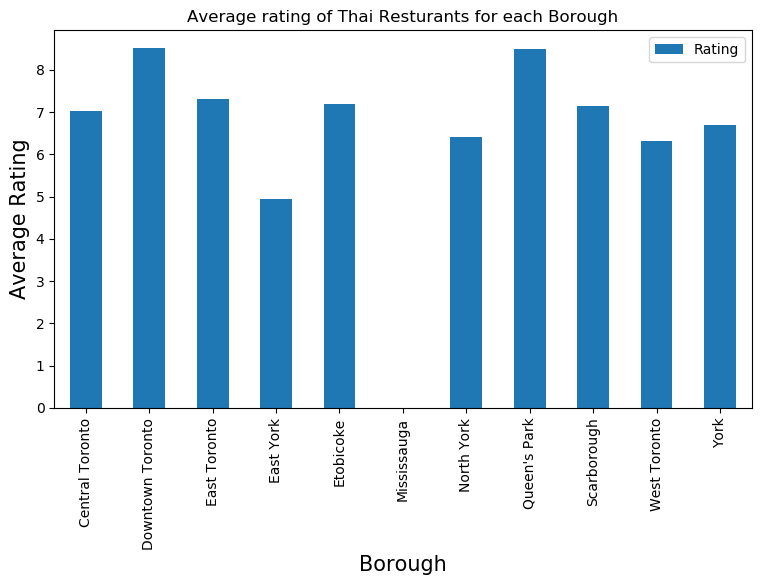

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Thai Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
thai_rest_stats_toronto.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on map

In [30]:
toronto_neighborhood_stats=toronto_neighborhood_stats[toronto_neighborhood_stats['Average Rating']>=7.0]
# ny_neighborhood_stats.head()

In [31]:
toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
20,"First Canadian Place,Underground city",9.0
16,"Design Exchange,Toronto Dominion Centre",9.0
0,"Adelaide,King,Richmond",8.7
32,Stn A PO Boxes 25 The Esplanade,8.7
31,St. James Town,8.7


We will join this dataset to original Toronto data to get lonitude and latitude

In [32]:
toronto_neighborhood_stats=pd.merge(toronto_neighborhood_stats,toronto_data, on='Neighborhood')


In [33]:
toronto_neighborhood_stats=toronto_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Neighborhood,Latitude,Longitude,Average Rating
13,Downtown Toronto,"First Canadian Place,Underground city",43.648429,-79.382280,9.0
11,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576,9.0
0,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,8.7
23,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,8.7
22,Downtown Toronto,St. James Town,43.651494,-79.375418,8.7


Now we will show this data on a map

In [34]:
# create map and display it
toronto_map = folium.Map(location=geo_location('Toronto,CA'), zoom_start=14)
toronto_neighborhood_stats.to_csv('toronto_neighborhood_vis.csv', index=False)
toronto_neighborhood_vis = pd.read_csv("toronto_neighborhood_vis.csv") 
toronto_neighborhood_vis.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,8.7
1,Downtown Toronto,Berczy Park,43.644771,-79.373306,8.7
2,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,8.4
3,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,7.6
4,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,8.4


In [35]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in toronto_neighborhood_vis[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
   

Lets add a new field to dataframe for labeling purpose

In [36]:
toronto_neighborhood_vis['Label']=toronto_neighborhood_stats['Neighborhood']+', '+toronto_neighborhood_stats['Borough']+'('+toronto_neighborhood_stats['Average Rating'].map(str)+')'

In [37]:
toronto_neighborhood_vis.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,8.7,"Adelaide,King,Richmond, Downtown Toronto(8.7)"
1,Downtown Toronto,Berczy Park,43.644771,-79.373306,8.7,"Berczy Park, Downtown Toronto(8.7)"
2,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,8.4,"Birch Cliff,Cliffside West, Scarborough(8.4)"
3,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,7.6,Business Reply Mail Processing Centre 969 East...
4,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,8.4,"Cabbagetown,St. James Town, Downtown Toronto(8.4)"


In [38]:
GeoJson = folium.Map(location=[43.6532, -79.3832], zoom_start=14, tiles = 'cartodbpositron')


In [39]:
import time
# Function to change the marker color  
# according to the elevation of volcano 
def color(avg): 
    if 6 <= avgr <= 7: 
        col = 'red'
    elif 7 <= avgr <= 8: 
        col = 'yellow'
    elif 8 <= avgr <= 9: 
        col = 'green'
    else: 
        col='blue'
    return col 
torontoMap = folium.Map(location=[43.6532, -79.3832], zoom_start=14)
toronto_geo = 'toronto_crs84.geojson'
GeoJson = folium.Map(location=[43.6532, -79.3832], zoom_start=14, tiles = 'cartodbpositron')

# add pop-up text to each marker on the map
for lat, lng, label,avgr in toronto_neighborhood_vis[['Latitude','Longitude','Label','Average Rating']].values:
    folium.Marker([lat, lng], popup=repr(avgr),icon=folium.Icon(color=color(avgr))).add_to(GeoJson) 
GeoJson

In [40]:
toronto_borough_stats=toronto_neighborhood_stats.groupby('Borough',as_index=False).mean()[['Borough','Latitude','Longitude','Average Rating']]
toronto_borough_stats.columns=['Borough','Latitude','Longitude','Average Rating']
toronto_borough_stats.head()

,Borough,Latitude,Longitude,Average Rating
0,Central Toronto,43.701292,-79.397586,7.333333
1,Downtown Toronto,43.654075,-79.379204,8.542308
2,East Toronto,43.661135,-79.331241,7.600000
3,East York,43.695344,-79.318389,7.100000
4,Etobicoke,43.641247,-79.513971,7.200000


In [41]:
for lat, lng, borough in toronto_borough_stats[['Latitude','Longitude','Borough']].values:
    folium.Circle([lat, lng], 1, fill=True).add_child(folium.Popup('1')).add_to(GeoJson)   
GeoJson



In [42]:
toronto_borough_stats=toronto_neighborhood_stats.groupby('Borough',as_index=False).mean()[['Borough','Latitude','Longitude','Average Rating']]
toronto_borough_stats.columns=['Borough','Latitude','Longitude','Average Rating']
toronto_borough_stats.head()
toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=14)
toronto_geo = r'toronto_crs84.geojson'
GeoJson.choropleth(
    geo_data=toronto_geo,
    data=toronto_borough_stats,
    columns=['Borough', 'Average Rating'],
    # key_on='feature.properties.AREA_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.01
)


In [43]:
for lat, lng, borough in toronto_borough_stats[['Latitude','Longitude','Borough']].values:
    folium.Circle([lat, lng], 5000, fill=True).add_child(folium.Popup(borough)).add_to(GeoJson)   
GeoJson


Now that we have visualized the Neighborhoods.
<br> In green maker show the Restaurants is rating between 8-9 point
<br> in Red maker show the Restaurants is Rating Between 0-7 Point


### Conclusion 
The best place to run the Thai food business is located in the Down Town area in Toronto, as it is considered rating, which means a lot of people who have been eating Thai food, heading Down to Town Down Town, to go to those Thai cusine.

### Limitations 
- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare